In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import json
import os

from cell_inference.config import paths, params
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere
from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

%matplotlib inline

## Load simulation data

In [2]:
DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Reduced_Order_trunkLR_Loc5_restrict_h')

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')  # trial configuration
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats.npz')  # summary statistics

STATS = np.load(STATS_PATH)
summ_stats = STATS['x']
labels = STATS['y']

with open(CONFIG_PATH, 'r') as f:
    config_dict = json.load(f)

inference_list = config_dict['Trial_Parameters']['inference_list']
ranges = config_dict['Simulation_Parameters']['loc_param_range']
ranges.update(config_dict['Simulation_Parameters']['geo_param_range'])

print(inference_list)

['y', 'd', 'theta', 'h', 'phi', 'l_t', 'r_t']


### Transform labels

#### Orientation

In [3]:
check_orient = 'h' in inference_list and 'phi' in inference_list
if check_orient:
    orient_idx0 = [inference_list.index(x) for x in ['h', 'phi']]
    orient_idx2 = orient_idx0.copy()

direction_vec = True # represent orientation by vector on unit sphere
direction_vec = direction_vec and check_orient

label_list = inference_list.copy()
if direction_vec:
    dv = hphi2unitsphere(labels[:, orient_idx0])
    labels = np.hstack([np.delete(labels, orient_idx0, axis=1), dv])
    
    orient_idx1 = list(range(len(inference_list) - 2, len(inference_list) + 1))
    orient_idx2 = [orient_idx1[1], len(inference_list) + 1]
    label_list.remove('h')
    label_list.remove('phi')
    label_list += ['vx', 'vy', 'vz']
    for i in orient_idx1:
        ranges[label_list[i]] = [-1., 1.]

display_list = label_list.copy()
if direction_vec:
    display_list[orient_idx1[1]] = 'vy / h'
    display_list.append('phi')

#### y shift

In [4]:
has_yshift = 'y' in label_list and STATS['ys'].size != 0
if has_yshift:
    ys_idx = label_list.index('y')
    labels[:,ys_idx] = STATS['ys']
    label_list[ys_idx] = 'ys'
    display_list[display_list.index('y')] = 'y-shift'

df_la = pd.DataFrame(labels, columns=label_list)
df_la.sort_values(by=df_la.columns[0],inplace=True)

with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,r_t,vx,vy,vz
2671,-155.648166,196.290758,0.583448,793.116436,0.516026,0.439722,0.891879,-0.105808
619,-144.432231,184.090896,0.355254,426.539641,0.626341,-0.502017,0.804944,0.316296
4412,-144.047718,198.559566,0.137342,662.990533,0.531696,0.008825,0.995996,0.088965
2537,-140.569666,165.522513,0.276566,898.684778,0.610068,0.044684,0.985036,0.166454
3119,-138.513753,189.364199,0.141048,726.028597,0.536835,0.330516,0.941004,0.072598
...,...,...,...,...,...,...,...,...
2820,250.847460,192.531412,-0.160088,699.211398,0.990915,0.038863,0.992983,-0.111689
1913,251.754981,194.369721,0.238725,409.396593,1.113721,-0.016228,0.995195,-0.096559
1274,252.209627,188.504392,0.138423,324.578901,1.091717,-0.080649,0.993132,-0.084766
4644,255.647154,198.938301,0.227363,965.647283,1.113860,0.144202,0.981565,-0.125443


### Normalizing labels

#### Set bounds for y shift

In [5]:
if has_yshift:
    ranges['ys'] = [-150, 150] # set bound for normalization
    df_la_idx = df_la[df_la['ys'].between(*ranges['ys'])].index.values
    print("%.2f%% outside bounds." % (100 - 100* len(df_la_idx) / len(df_la.index)))
#     labels = labels[df_la_idx,:]
#     summ_stats = summ_stats[df_la_idx,:]
#     with pd.option_context('display.max_rows',10):
#         display(df_la.loc[df_la_idx])

print(json.dumps(ranges))

12.61% outside bounds.
{"x": [-50, 50], "y": [-750.0, 750.0], "z": [50.0, 200.0], "alpha": [0, 3.141592653589793], "h": [0.7071, 1.0], "phi": [-3.141592653589793, 3.141592653589793], "d": [50.0, 200.0], "theta": [-1.0471975511965976, 1.0471975511965976], "l_t": [200.0, 1000.0], "r_t": [0.5, 1.5], "vx": [-1.0, 1.0], "vy": [-1.0, 1.0], "vz": [-1.0, 1.0], "ys": [-150, 150]}


#### Normalization

In [6]:
feature_range = (-1, 1)
norm_scale = lambda x, r: (x - r[0]) / (r[1] - r[0]) * (feature_range[1] - feature_range[0]) + feature_range[0]
org_scale = lambda x, r: (x - feature_range[0]) / (feature_range[1] - feature_range[0]) *  (r[1] - r[0]) + r[0]

for i, lb in enumerate(label_list):
    labels[:,i] = norm_scale(labels[:,i], ranges[lb])

df_la = pd.DataFrame(labels, columns=label_list)
with pd.option_context('display.max_rows',10):
    display(df_la)

,ys,d,theta,l_t,r_t,vx,vy,vz
0,0.207871,-0.545328,0.037867,-0.223231,-0.093732,-0.138682,0.860801,0.489683
1,0.161778,-0.366483,0.533298,-0.223231,-0.093732,0.662879,0.740817,-0.108540
2,0.151728,0.594731,-0.118573,-0.223231,-0.093732,-0.233748,0.905104,0.355175
3,0.401600,0.352509,-0.009053,-0.223231,-0.093732,-0.179952,0.720016,0.670220
4,0.697620,-0.217781,-0.441136,-0.223231,-0.093732,0.144645,0.820484,-0.553067
...,...,...,...,...,...,...,...,...
5982,-0.042130,-0.160493,-0.834186,0.014458,0.216096,-0.336148,0.938450,0.079471
5983,1.092661,-0.212319,0.047885,0.014458,0.216096,-0.310209,0.882788,-0.352782
5984,-0.055777,-0.082288,0.185007,0.014458,0.216096,0.591362,0.804725,-0.052043
5985,1.275133,0.841172,-0.103618,0.014458,0.216096,-0.141611,0.840166,-0.523514


## Build model

In [7]:
import torch
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
# from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork

isTrain = False
model_name = 'FCN_batch256'
if direction_vec:
    model_name += '_dv'
MODEL_PATH = os.path.join(TRIAL_PATH, model_name + '.pth')
SAVE_PATH = os.path.join(TRIAL_PATH, model_name + '.txt')

model = FullyConnectedNetwork(in_features=summ_stats.shape[1], out_features=len(label_list))

## Train model

In [8]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

train_loader, test_loader = build_dataloader_from_numpy(input_arr=summ_stats, labels_arr=labels, batch_size=256, shuffle=True)
if isTrain:
    history, files = train_regression(model, train_loader, test_loader, epochs=100, learning_rate=0.001, decay_rate=0.98)
    model.eval()
    torch.save(model.state_dict(), MODEL_PATH)
    with open(SAVE_PATH, 'w') as f:
        f.writelines(s + '\n' for s in files)

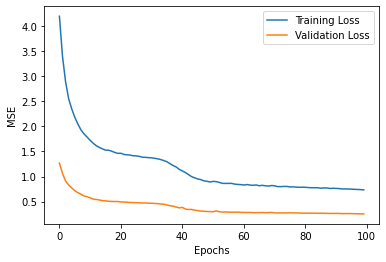

In [9]:
if not isTrain:
    with open(SAVE_PATH, 'r') as f:
        loss_file = f.read().splitlines()[1]
    history = pd.read_csv(loss_file).to_dict(orient='list')
plt.figure()
plt.plot(history['Epochs'],history['Training_Loss'],label='Training Loss')
plt.plot(history['Epochs'],history['Validation_Loss'],label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

## Evaluate model

In [10]:
if not isTrain:
    model.load_state_dict(torch.load(MODEL_PATH))

### Perform on stylized model

In [19]:
from sklearn.metrics import r2_score
from cell_inference.utils.metrics.corrcoef import corrcoef

device = torch.device("cpu")
model.eval()

y = []
output = []
for X, Y in test_loader:
    y.append(Y.to("cpu").detach().numpy())
    output.append(model(X.to(device)).to("cpu").detach().numpy())
y = np.concatenate(y, axis=0)
output = np.concatenate(output, axis=0)

# back to original scale
for i, lb in enumerate(label_list):
    y[:, i] = org_scale(y[:, i], ranges[lb])
    output[:, i] = org_scale(output[:, i], ranges[lb])

# transform orientation variables
if direction_vec:
    output[:, orient_idx1] = trivarnorm2unitsphere(output[:, orient_idx1])
    y = np.hstack([y, unitsphere2hphi(y[:, orient_idx1])[:, [1]]])
    output = np.hstack([output, unitsphere2hphi(output[:, orient_idx1])[:, [1]]])

# print("R2: {}".format(r2_score(y, output)))
print('R2 Score:')
for i, p in enumerate(display_list):
    print('{:10} {:.3f}'.format(p+',', r2_score(y[:, i], output[:, i])))

R2 Score:
y-shift,   0.920
d,         0.967
theta,     0.505
l_t,       0.766
r_t,       0.959
vx,        0.215
vy / h,    -1.068
vz,        0.716
phi,       -0.372


Stylized Cell Testing Data: Ground Truth VS Predicted


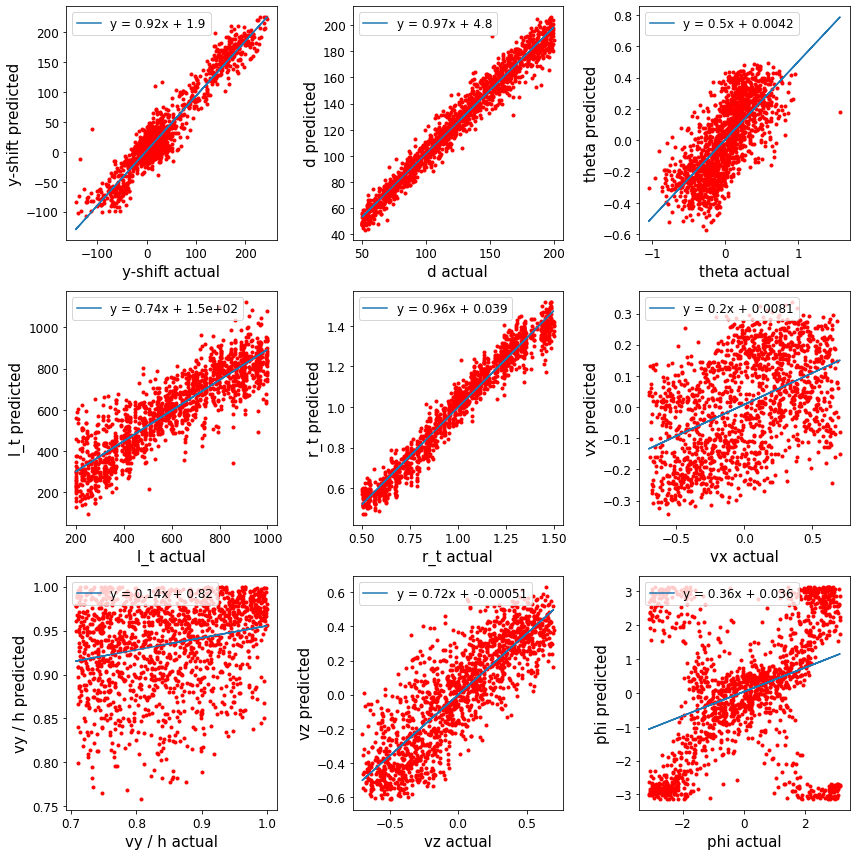

In [12]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Stylized Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(y[:, i], output[:, i], c='red', marker='.')
    m, b = np.polyfit(y[:, i], output[:, i], 1)
    ax.plot(y[:, i], m * y[:, i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

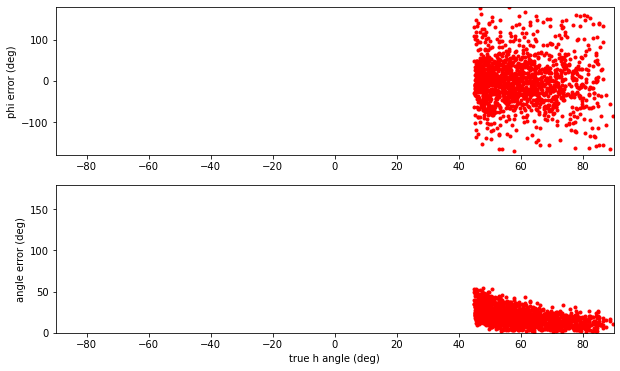

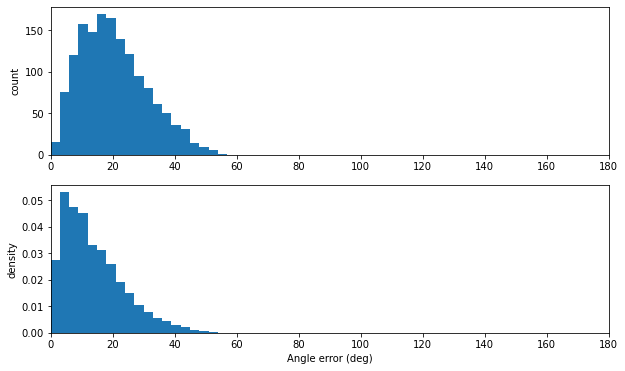

RMSE of angle: 23.1


In [13]:
if check_orient:
    def cosine_similarity(hphi1, hphi2):
        np.clip(hphi1[:,0], -1, 1, out=hphi1[:,0])
        np.clip(hphi2[:,0], -1, 1, out=hphi2[:,0])
        x1 = hphi2unitsphere(hphi1)
        x2 = hphi2unitsphere(hphi2)
        return np.sum(x1 * x2, axis=1)

    bins = 60
    angle = np.arccos(cosine_similarity(y[:, orient_idx2], output[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 4))
    angle *= 180 / np.pi
    phi_err = 180 / np.pi * (output[:, orient_idx2[1]] - y[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(y[:, orient_idx2[0]])

    plt.figure(figsize=(10,6))
    # phi error vs. h angle
    plt.subplot(211)
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-180, 180])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(212)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 180])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error distribution
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 180))
    plt.xlim([0, 180])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 180), density=True, weights=weights)
    plt.xlim([0, 180])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)

### Perform on detailed model (Random cases)

In [14]:
LFP_PATH = os.path.join(TRIAL_PATH, 'lfp_detailed.npz')  # LFP and labels
STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed.npz')  # summary statistics
# STATS_PATH = os.path.join(TRIAL_PATH, 'summ_stats_detailed_strch.npz')  # summary statistics

#### Ground truth

In [15]:
STATS = np.load(STATS_PATH)
summ_stats_test = STATS['x']
labels_true = STATS['y']
if direction_vec:
    dv = hphi2unitsphere(labels_true[:, orient_idx0])
    labels_true = np.hstack([np.delete(labels_true, orient_idx0, axis=1), dv, labels_true[:, [orient_idx0[1]]]])
if has_yshift:
    labels_true[:, ys_idx] = STATS['ys']

FileNotFoundError: [Errno 2] No such file or directory: 'cell_inference/resources/simulation_data\\Reduced_Order_trunkLR_Loc5_restrict_h\\summ_stats_detailed.npz'

#### Prediction

In [ ]:
device = torch.device("cpu")
model.eval()

labels_pred = model(torch.Tensor(summ_stats_test).to(device)).to("cpu").detach().numpy()

# back to original scale
for i, lb in enumerate(label_list):
    labels_pred[:, i] = org_scale(labels_pred[:, i], ranges[lb])

# transform orientation variables
if direction_vec:
    labels_pred[:, orient_idx1] = trivarnorm2unitsphere(labels_pred[:, orient_idx1])
    labels_pred = np.hstack([labels_pred, unitsphere2hphi(labels_pred[:, orient_idx1])[:, [1]]])

print('R2 Score:')
for i, p in enumerate(display_list):
    print('{:10} {:.3f}'.format(p+',', r2_score(labels_true[:, i], labels_pred[:, i])))

In [ ]:
nlb = len(display_list)
nrows = int(np.ceil(nlb/3))

fontsize = 15
labelsize = 12
print("Detailed Cell Testing Data: Ground Truth VS Predicted")

plt.figure(figsize=(12, 4 * nrows))
for i, lb in enumerate(display_list):
    ax = plt.subplot(nrows, 3, i+1)
    ax.scatter(labels_true[:, i], labels_pred[:, i], c='red', marker='.')
    m, b = np.polyfit(labels_true[:, i], labels_pred[:, i], 1)
    ax.plot(labels_true[:, i], m * labels_true[:, i] + b, label='y = %.2gx + %.2g' % (m,b))
    ax.set_xlabel(lb + ' actual', fontsize=fontsize)
    ax.set_ylabel(lb + ' predicted', fontsize=fontsize)
    ax.tick_params(labelsize=labelsize)
    ax.legend(loc=2, fontsize=labelsize)
plt.tight_layout()
plt.show()

#### Check prediction on orientation

In [ ]:
if check_orient:
    bins = 30
    angle = np.arccos(cosine_similarity(labels_true[:, orient_idx2], labels_pred[:, orient_idx2]))
    weights = 1 / np.sin(np.fmax(angle, np.pi / bins / 4))
    angle *= 180 / np.pi
    phi_err = 180 / np.pi * (labels_pred[:, orient_idx2[1]] - labels_true[:, orient_idx2[1]])
    phi_err = np.mod(phi_err + 180, 360) - 180
    h_angle = 90 - 180 / np.pi * np.arccos(labels_true[:, orient_idx2[0]])

    plt.figure(figsize=(10,6))
    # phi error vs. h angle
    plt.subplot(211)
    plt.plot(h_angle, phi_err, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([-180, 180])
    plt.ylabel('phi error (deg)')
    # angle error vs. h angle
    plt.subplot(212)
    plt.plot(h_angle, angle, 'r.')
    plt.xlim([-90, 90])
    plt.ylim([0, 180])
    plt.xlabel('true h angle (deg)')
    plt.ylabel('angle error (deg)')

    # angle error distribution
    plt.figure(figsize=(10,6))
    plt.subplot(211)
    _ = plt.hist(angle, bins=bins, range=(0, 180))
    plt.xlim([0, 180])
    plt.ylabel('count')
    plt.subplot(212)
    _ = plt.hist(angle, bins=bins, range=(0, 180), density=True, weights=weights)
    plt.xlim([0, 180])
    plt.ylabel('density') # probability density of angle error per area on the unit sphere
    plt.xlabel('Angle error (deg)')

    plt.show()

    print("RMSE of angle: %.1f" % np.mean(angle ** 2) ** .5)